In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import control as ctl

In [3]:
# Carregar os dados do arquivo MAT
arquivo_mat = r'../Dataset/Dataset_Grupo6.mat'
Dados = scipy.io.loadmat(arquivo_mat)

print(Dados.keys())

print(Dados['reactionExperiment'][0, 0].dtype)

dict_keys(['__header__', '__version__', '__globals__', 'reactionExperiment'])
[('sampleTime', 'O'), ('dataInput', 'O'), ('dataOutput', 'O'), ('physicalQuantity', 'O'), ('units', 'O')]


In [4]:
# Extrair os dados
tempo = Dados['reactionExperiment'][0, 0]['sampleTime'][:, 0]
degrau = Dados['reactionExperiment'][0, 0]['dataInput'][:, 0]
Temp_glicerina = Dados['reactionExperiment'][0, 0]['dataOutput'][:, 0]

# Imprimir os shapes para confirmação
print("\nShape do tempo:", tempo.shape)
print("Shape do degrau:", degrau.shape)
print("Shape da temperatura da glicerina:", Temp_glicerina.shape)

# Imprimir todos os valores (lembre-se que pode ser uma saída longa)
print("\nValores do tempo:", tempo)
print("Valores do degrau:", degrau)
print("Valores da temperatura da glicerina:", Temp_glicerina)


Shape do tempo: (6773,)
Shape do degrau: (6773,)
Shape da temperatura da glicerina: (6773,)

Valores do tempo: [    0     5    10 ... 33850 33855 33860]
Valores do degrau: [91.38299613 90.9759488  91.35968105 ... 90.98453412 91.3185383
 90.7926712 ]
Valores da temperatura da glicerina: [  9.1053052    9.06474743   9.10298211 ... 453.13304764 454.79654566
 452.17759996]


In [5]:
# Determinar o valor final da resposta e amplitude do degrau
amplitude_degrau = degrau[-1]
valor_final = Temp_glicerina[-1]

print(f"Amplitude do degrau: {amplitude_degrau}")
print(f"Valor final da resposta da temperatura da glicerina: {valor_final}")

Amplitude do degrau: 90.79267120067702
Valor final da resposta da temperatura da glicerina: 452.1775999590113


In [6]:
def encontrar_tempo_morto(tempo, saida, limiar_desvio):
    """
    Estima o tempo morto encontrando o primeiro instante em que a saída
    se desvia significativamente do valor inicial.

    Args:
        tempo (np.ndarray): Vetor de tempo.
        saida (np.ndarray): Vetor da saída do sistema.
        limiar_desvio (float): A magnitude mínima da mudança na saída
                                 para ser considerada o início da resposta.

    Returns:
        float: O tempo estimado do final do tempo morto.
               Retorna None se nenhum desvio significativo for encontrado.
    """
    valor_inicial_saida = np.mean(saida[:10])  # Média dos primeiros pontos para considerar o valor inicial

    for i in range(len(saida)):
        desvio = abs(saida[i] - valor_inicial_saida)
        if desvio > limiar_desvio:
            return tempo[i]
    return None

# Definir um limiar de desvio
limiar = 0.05 * (np.max(Temp_glicerina) - np.min(Temp_glicerina)) # Exemplo: 5% da variação total

tempo_morto_estimado = encontrar_tempo_morto(tempo, Temp_glicerina, limiar)

if tempo_morto_estimado is not None:
    print(f"Tempo morto estimado: {tempo_morto_estimado} segundos")

    # Encontrar o índice correspondente ao tempo morto
    indice_tempo_morto = np.argmin(np.abs(tempo - tempo_morto_estimado))

    # Criar vetores de tempo e saída "ativos" (após o tempo morto)
    tempo_ativo = tempo[indice_tempo_morto:] - tempo_morto_estimado
    saida_ativa = Temp_glicerina[indice_tempo_morto:]

    # Agora você pode usar tempo_ativo e saida_ativa para calcular tau
    # com os métodos de Smith ou Sundaresan (adaptando a função se necessário)

else:
    print("Não foi possível estimar o tempo morto com o limiar definido.")

Tempo morto estimado: 1685 segundos


In [7]:
# Tempo morto estimado
tempo_morto_estimado = 1685.0

# Encontrar o índice correspondente ao tempo morto
indice_tempo_morto = np.argmin(np.abs(tempo - tempo_morto_estimado))

# Criar vetores de tempo e saída "ativos" (após o tempo morto)
tempo_ativo = tempo[indice_tempo_morto:] - tempo_morto_estimado
saida_ativa = Temp_glicerina[indice_tempo_morto:]

# Imprimir os shapes para verificar
print("\nShape do tempo ativo:", tempo_ativo.shape)
print("Shape da saída ativa:", saida_ativa.shape)



Shape do tempo ativo: (6436,)
Shape da saída ativa: (6436,)


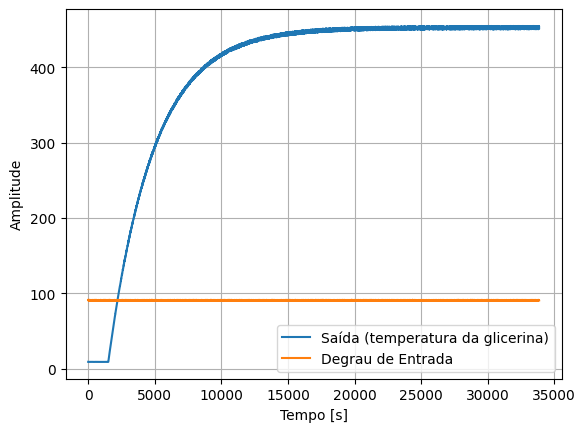

In [8]:
# Plotar o gráfico de entrada e saída
plt.plot(tempo, Temp_glicerina, label='Saída (temperatura da glicerina)')
plt.plot(tempo, degrau, label='Degrau de Entrada')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.legend(loc="lower right")
plt.grid()
plt.savefig('images/Entrada_Saida.png')
plt.show()

In [9]:
def SmithAndSundaresan_modificado(Tempo_ativo, Saida_ativa, valor_final, valor_inicial, Method, amplitude_degrau):
    """
    Calcula o ganho estático (K) e a constante de tempo (tau) usando os métodos
    de Smith ou Sundaresan com dados ativos (após a remoção do tempo morto).
    O tempo morto (theta) deve ser estimado separadamente.

    Args:
        Tempo_ativo (np.ndarray): Vetor de tempo após o tempo morto, começando em zero.
        Saida_ativa (np.ndarray): Vetor da saída correspondente.
        valor_final (float): Valor final da saída em regime permanente.
        valor_inicial (float): Valor inicial da saída.
        Method (str): Método a ser usado ("Smith" ou qualquer outro para Sundaresan).
        amplitude_degrau (float): Amplitude total do degrau de entrada.

    Returns:
        tuple: O ganho estático (K) e a constante de tempo (tau) estimados.
               Retorna (None, None) se os critérios não forem atendidos.
    """
    K = (valor_final - valor_inicial) / amplitude_degrau
    delta_saida = valor_final - valor_inicial
    tempo_t1 = None
    tempo_t2 = None
    tau = None

    if Method == "Smith":
        nivel_t1 = valor_inicial + 0.283 * delta_saida
        nivel_t2 = valor_inicial + 0.632 * delta_saida
    else:  # Sundaresan
        nivel_t1 = valor_inicial + 0.353 * delta_saida
        nivel_t2 = valor_inicial + 0.853 * delta_saida

    for i in range(len(Saida_ativa)):
        if Saida_ativa[i] >= nivel_t1 and tempo_t1 is None:
            tempo_t1 = Tempo_ativo[i]
        if Saida_ativa[i] >= nivel_t2:
            tempo_t2 = Tempo_ativo[i]
            break

    if tempo_t1 is not None and tempo_t2 is not None:
        if Method == "Smith":
            tau = 1.5 * (tempo_t2 - tempo_t1)
        else:  # Sundaresan
            tau = (2/3) * (tempo_t2 - tempo_t1)

    return K, tau

valor_inicial_saida = np.mean(Temp_glicerina[:10])
valor_final_saida = np.mean(Temp_glicerina[-500:])
amplitude_degrau_correta = 90.79267120067702
metodo_identificacao = "Smith"  # ou "Sundaresan"

K_estimado, tau_estimado = SmithAndSundaresan_modificado(tempo_ativo, saida_ativa, valor_final_saida, valor_inicial_saida, metodo_identificacao, amplitude_degrau_correta)
tempo_morto_estimado = 1685.0  # Valor estimado anteriormente

if K_estimado is not None and tau_estimado is not None:
    print(f"Ganho estático (K) estimado: {K_estimado}")
    print(f"Constante de tempo (tau) estimada: {tau_estimado} segundos")
    print(f"Tempo morto (theta) estimado: {tempo_morto_estimado} segundos")
else:
    print("Não foi possível estimar K e/ou tau com os dados ativos.")

Ganho estático (K) estimado: 4.888310586398808
Constante de tempo (tau) estimada: 3382.5 segundos
Tempo morto (theta) estimado: 1685.0 segundos


In [10]:
# Valor inicial e final da saída
valor_inicial_saida = np.mean(Temp_glicerina[:10])
valor_final_saida = np.mean(Temp_glicerina[-500:])

# Amplitude do degrau
amplitude_degrau_correta = 90.79267120067702

# Tempo morto estimado
tempo_morto_estimado = 1685.0

# Encontrar o índice correspondente ao tempo morto
indice_tempo_morto = np.argmin(np.abs(tempo - tempo_morto_estimado))

# Criar vetores de tempo e saída "ativos" (após o tempo morto)
tempo_ativo = tempo[indice_tempo_morto:] - tempo_morto_estimado
saida_ativa = Temp_glicerina[indice_tempo_morto:]

# Declarando Valor de Tau e Theta de acordo com o método de identificação utilizado

##SMITH
K_smith, tau_smith = SmithAndSundaresan_modificado(tempo_ativo, saida_ativa, valor_final_saida, valor_inicial_saida, "Smith", amplitude_degrau_correta)
theta_smith = tempo_morto_estimado

##SUNDARESAN
K_sundaresan, tau_sundaresan = SmithAndSundaresan_modificado(tempo_ativo, saida_ativa, valor_final_saida, valor_inicial_saida, "Sundaresan", amplitude_degrau_correta)
theta_sundaresan = tempo_morto_estimado

print("\nResultados (Smith):")
print(f"Ganho estático (K): {K_smith}")
print(f"Constante de tempo (tau): {tau_smith} segundos")
print(f"Tempo morto (theta): {theta_smith} segundos")

print("\nResultados (Sundaresan):")
print(f"Ganho estático (K): {K_sundaresan}")
print(f"Constante de tempo (tau): {tau_sundaresan} segundos")
print(f"Tempo morto (theta): {theta_sundaresan} segundos")


Resultados (Smith):
Ganho estático (K): 4.888310586398808
Constante de tempo (tau): 3382.5 segundos
Tempo morto (theta): 1685.0 segundos

Resultados (Sundaresan):
Ganho estático (K): 4.888310586398808
Constante de tempo (tau): 3296.6666666666665 segundos
Tempo morto (theta): 1685.0 segundos


In [11]:
tempo = tempo.astype(float)

# Amplitude do degrau correta
amplitude_degrau_correta = 90.79267120067702

# Tempo morto estimado
tempo_morto_estimado = 1685.0

# Encontrar o índice correspondente ao tempo morto
indice_tempo_morto = np.argmin(np.abs(tempo - tempo_morto_estimado))

# Criar vetor de tempo para a simulação (começando em zero e com a mesma duração da resposta ativa)
tempo_simulacao = tempo_ativo

# ERRO QUADRATICO DE SMITH
sistema_smith = ctl.tf(K_smith, [tau_smith, 1])
num_delay_smith, den_delay_smith = ctl.pade(theta_smith, 20)
sistema_com_theta_smith = ctl.series(ctl.tf(num_delay_smith, den_delay_smith), sistema_smith)
t_sim_smith, saida_simulada_smith = ctl.step_response(
    sistema_com_theta_smith * amplitude_degrau_correta, tempo_simulacao
)

# Alinhar os vetores para o cálculo do erro (comparar a saída simulada com a parte da saída real após o tempo morto)
if len(saida_simulada_smith) > len(saida_ativa):
    saida_simulada_smith = saida_simulada_smith[:len(saida_ativa)]
elif len(saida_simulada_smith) < len(saida_ativa):
    saida_ativa_comparacao = saida_ativa[:len(saida_simulada_smith)]
else:
    saida_ativa_comparacao = saida_ativa

erro_smith = np.sqrt(np.mean((saida_simulada_smith - saida_ativa_comparacao) ** 2))

# ERRO QUADRATICO DE SUNDARESAN
sistema_sundaresan = ctl.tf(K_sundaresan, [tau_sundaresan, 1])
num_delay_sundaresan, den_delay_sundaresan = ctl.pade(theta_sundaresan, 20)
sistema_com_theta_sundaresan = ctl.series(ctl.tf(num_delay_sundaresan, den_delay_sundaresan), sistema_sundaresan)
t_sim_sundaresan, saida_simulada_sundaresan = ctl.step_response(
    sistema_com_theta_sundaresan * amplitude_degrau_correta, tempo_simulacao
)

# Alinhar os vetores para o cálculo do erro
if len(saida_simulada_sundaresan) > len(saida_ativa):
    saida_simulada_sundaresan = saida_simulada_sundaresan[:len(saida_ativa)]
elif len(saida_simulada_sundaresan) < len(saida_ativa):
    saida_ativa_comparacao = saida_ativa[:len(saida_simulada_sundaresan)]
else:
    saida_ativa_comparacao = saida_ativa

erro_sundaresan = np.sqrt(np.mean((saida_simulada_sundaresan - saida_ativa_comparacao) ** 2))

if erro_smith < erro_sundaresan:
    tau_estimado = tau_smith
    theta_estimado = theta_smith
    nome = "Smith"
    EQM = erro_smith
else:
    tau_estimado = tau_sundaresan
    theta_estimado = theta_sundaresan
    nome = "Sundaresan"
    EQM = erro_sundaresan

print(
    f"K = {K_smith:.4f}, Tau = {tau_estimado:.4f}, Theta = {theta_estimado:.4f}. \nModelo utilizado foi de {nome} com EQM = {EQM:.4f}"
)

K = 4.8883, Tau = 3296.6667, Theta = 1685.0000. 
Modelo utilizado foi de Sundaresan com EQM = 55.1026


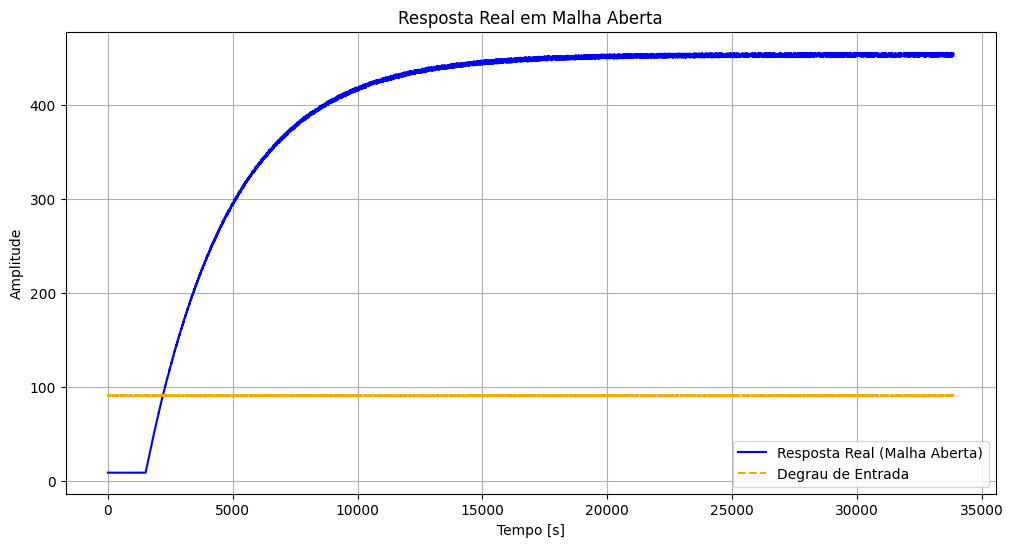

In [12]:
sistema_sundaresan = ctl.tf(K_sundaresan, [tau_sundaresan, 1])
num_delay_sundaresan, den_delay_sundaresan = ctl.pade(theta_sundaresan, 20)
sistema_com_theta_sundaresan = ctl.series(ctl.tf(num_delay_sundaresan, den_delay_sundaresan), sistema_sundaresan)
t_sim_aberta, saida_simulada_aberta = ctl.step_response(
    sistema_com_theta_sundaresan * amplitude_degrau_correta, tempo
)

# Plotar o gráfico de entrada e saída
plt.figure(figsize=(12, 6))
plt.plot(tempo, Temp_glicerina, label='Resposta Real (Malha Aberta)', color='blue')
plt.plot(tempo, degrau, label='Degrau de Entrada', linestyle='--', color='orange')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.title('Resposta Real em Malha Aberta')
plt.legend(loc="lower right")
plt.grid()
plt.savefig('images/Resposta em Malha Aberta.png')
plt.show()



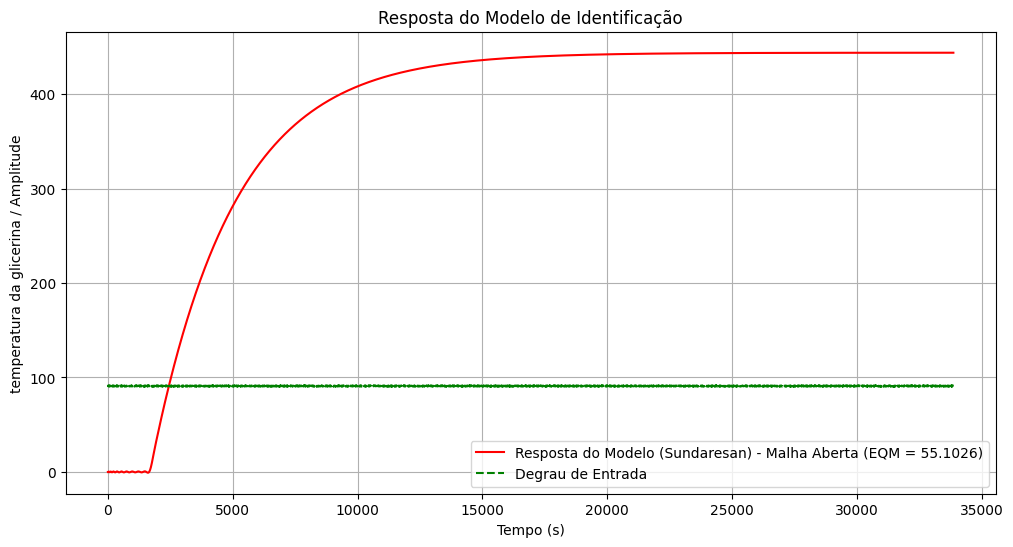

In [14]:
# Plotar a resposta do modelo e o degrau de entrada
plt.figure(figsize=(12, 6))
plt.plot(t_sim_aberta, saida_simulada_aberta, label=f'Resposta do Modelo (Sundaresan) - Malha Aberta (EQM = {EQM:.4f})', color='red')
plt.plot(tempo, degrau, label='Degrau de Entrada', linestyle='--', color='green')
plt.xlabel('Tempo (s)')
plt.ylabel('temperatura da glicerina / Amplitude')
plt.title('Resposta do Modelo de Identificação')
plt.legend()
plt.grid(True)
plt.savefig('images/Modelo de identificacao.png')
plt.show()

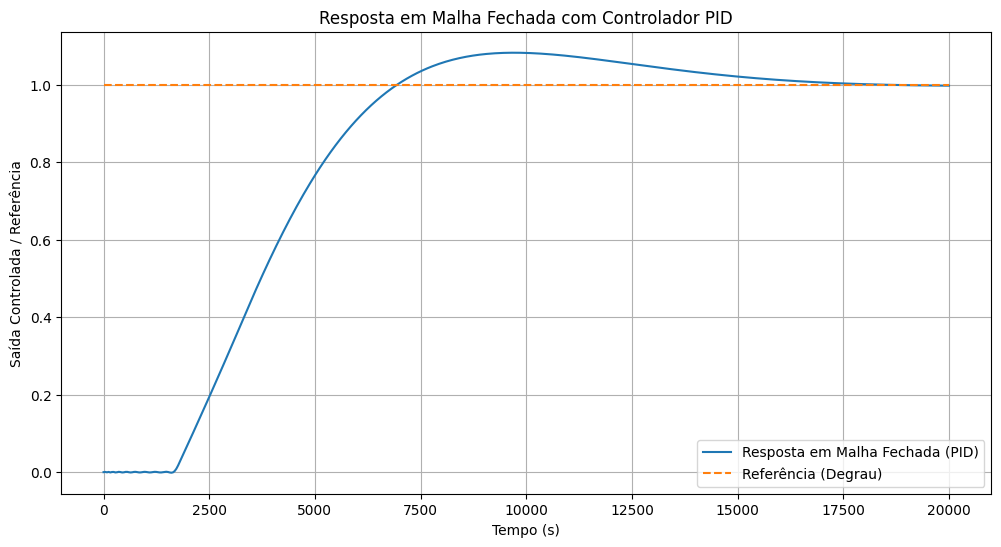

In [13]:
import control as ctl
import numpy as np
import matplotlib.pyplot as plt

Kp = 0.006  # Alterada para estabilizar o sistema
Ki = Kp / 100 # Alterada para estabilizar o sistema
Kd = Kp * 250 ## Alterada para estabilizar o sistema

# Criando as funções de transferência para as partes do PID
P = ctl.TransferFunction([Kp], [1])
I = ctl.TransferFunction([Ki], [1, 0])
D = ctl.TransferFunction([Kd * 0.1], [1, 1])

# Controlador PID completo
controlador_pid = P + I + D

# Função de transferência da planta (modelo de Sundaresan com aproximação de Padé para o atraso)
K_sundaresan = 4.8883
tau_sundaresan = 3296.6667
theta_sundaresan = 1685.0
num_delay_sundaresan, den_delay_sundaresan = ctl.pade(theta_sundaresan, 20)
planta = ctl.TransferFunction([K_sundaresan], [tau_sundaresan, 1])
sistema_com_theta_sundaresan = ctl.series(ctl.TransferFunction(num_delay_sundaresan, den_delay_sundaresan), planta)

# Sistema em malha fechada com realimentação unitária
sistema_malha_fechada = ctl.feedback(controlador_pid * sistema_com_theta_sundaresan, 1)

referencia = 1.0  # Amplitude do degrau de referência (você pode ajustar)
tempo_simulacao_fechada = np.linspace(0, 20000, 500) # Definir um vetor de tempo para a simulação
t_sim_fechada, saida_simulada_fechada = ctl.step_response(referencia * sistema_malha_fechada, tempo_simulacao_fechada)

# Criar o sinal de referência para plotagem
tempo_referencia = tempo_simulacao_fechada
sinal_referencia = np.ones_like(tempo_referencia) * referencia

# Plotar a resposta em malha fechada e o degrau de entrada
plt.figure(figsize=(12, 6))
plt.plot(t_sim_fechada, saida_simulada_fechada, label='Resposta em Malha Fechada (PID)')
plt.plot(tempo_referencia, sinal_referencia, label='Referência (Degrau)', linestyle='--') # Adicionado o degrau de entrada
plt.xlabel('Tempo (s)')
plt.ylabel('Saída Controlada / Referência')
plt.title('Resposta em Malha Fechada com Controlador PID')
plt.legend()
plt.grid(True)
plt.savefig('images/Resposta em Malha Fechada com Controlador PID.png')
plt.show()


CONTROLADOR - CHR (Sem Sobressinal)
Kp = 0.2000, Ti = 3900.00, Td = 350.00.
OVERSHOOT com CHR: 0.0000%.


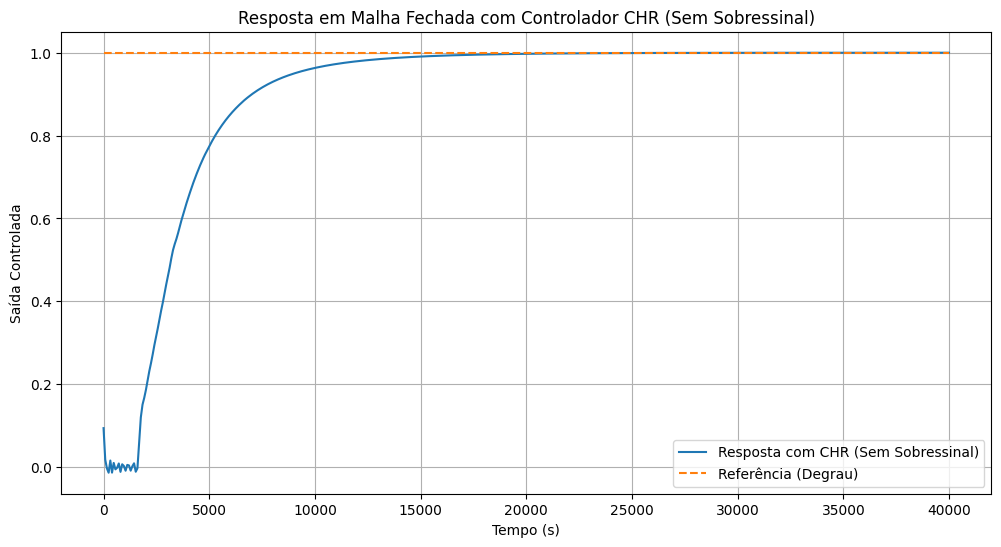

In [28]:
K = 4.8883
tau_estimado = 3296.67
theta_estimado = 1685.0

# Parâmetros da simulação
amplitude_degrau = 1.0
tempo_simulacao = np.linspace(0, 40000, 500) # Ajuste o tempo de simulação conforme necessário

# Aproximação de Padé para o tempo morto
num_delay, den_delay = ctl.pade(theta_estimado, 20)

# --- Controlador CHR (sem sobressinal) ---

def CHR(kp_chr, ti_chr, td_chr):
    print("\nCONTROLADOR - CHR (Sem Sobressinal)")
    print(f"Kp = {kp_chr:.4f}, Ti = {ti_chr:.2f}, Td = {td_chr:.2f}.")

    controlador_chr_num = [kp_chr * td_chr, kp_chr, kp_chr / ti_chr]
    controlador_chr_den = [1, 0]
    controlador_chr = ctl.tf(controlador_chr_num, controlador_chr_den)

    # Planta com tempo morto
    planta_com_theta = ctl.series(ctl.tf(num_delay, den_delay), ctl.tf([K], [tau_estimado, 1]))

    # Sistema em malha fechada com o controlador CHR
    sistema_chr_controlado = ctl.feedback(controlador_chr * planta_com_theta, 1)
    tempo_chr, saida_chr = ctl.step_response(amplitude_degrau * sistema_chr_controlado, tempo_simulacao)

    # Informações do sobressinal do CHR
    informacoes_chr = ctl.step_info(sistema_chr_controlado)
    sobressinal_chr = informacoes_chr.get('Overshoot', 0) # Usar .get() para evitar KeyError se não houver overshoot
    print(f'OVERSHOOT com CHR: {sobressinal_chr:.4f}%.')
    return (tempo_chr, saida_chr, sistema_chr_controlado) # Retornando o sistema controlado

# --- Calcular e Simular o Controlador CHR ---

# Parâmetros CHR (calculados anteriormente)
kp_chr = 0.2
ti_chr = 3900
td_chr = 350

tempo_chr, saida_chr, sistema_chr_controlado = CHR(kp_chr, ti_chr, td_chr)

# --- Plotar a Resposta com CHR ---

plt.figure(figsize=(12, 6))
plt.plot(tempo_chr, saida_chr, label='Resposta com CHR (Sem Sobressinal)')
plt.plot(tempo_simulacao, np.ones_like(tempo_simulacao) * amplitude_degrau, label='Referência (Degrau)', linestyle='--')
plt.xlabel('Tempo (s)')
plt.ylabel('Saída Controlada')
plt.title('Resposta em Malha Fechada com Controlador CHR (Sem Sobressinal)')
plt.legend()
plt.grid(True)
plt.savefig('images/Resposta em Malha Fechada com Controlador CHR (Sem Sobressinal).png')
plt.show()


CONTROLADOR - ITAE
Kp = 0.3492, Ti = 4573.21, Td = 544.31.
OVERSHOOT com ITAE: 0.0000%.


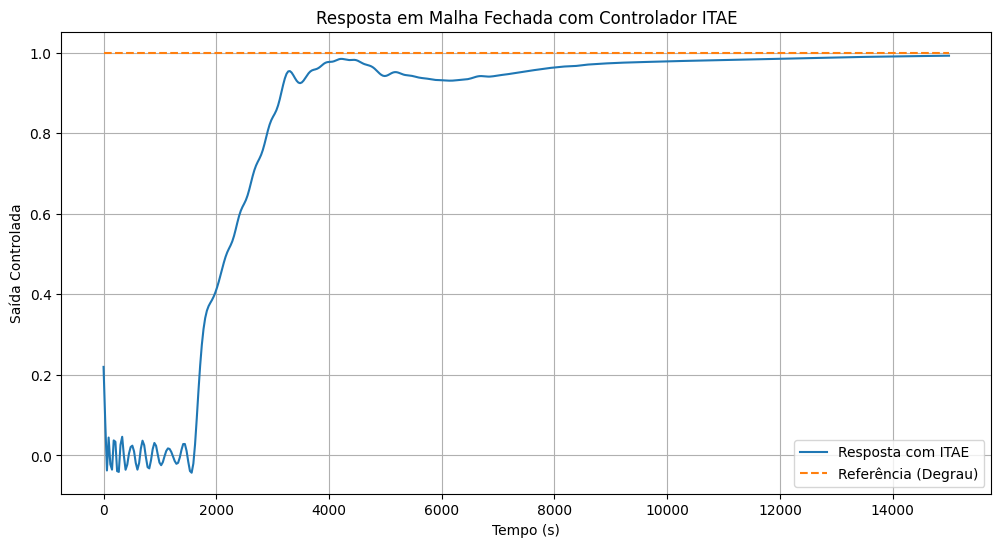

In [ ]:

# Parâmetros estimados do sistema
K = 4.8883
tau_estimado = 3296.67
theta_estimado = 1685.0

amplitude_degrau = 1.0
tempo_simulacao = np.linspace(0, 15000, 500) # Ajuste o tempo de simulação conforme necessário

# Aproximação de Padé para o tempo morto
num_delay, den_delay = ctl.pade(theta_estimado, 20)

# Planta com tempo morto
planta_com_theta = ctl.series(ctl.tf(num_delay, den_delay), ctl.tf([K], [tau_estimado, 1]))

# --- Controlador ITAE ---

def ITAE_controller(kp_itae, ti_itae, td_itae):
    print("\nCONTROLADOR - ITAE")
    print(f"Kp = {kp_itae:.4f}, Ti = {ti_itae:.2f}, Td = {td_itae:.2f}.")

    controlador_itae_num = [kp_itae * td_itae, kp_itae, kp_itae / ti_itae]
    controlador_itae_den = [1, 0]
    controlador_itae = ctl.tf(controlador_itae_num, controlador_itae_den)
    return controlador_itae

# --- Calcular os parâmetros do Controlador ITAE ---

a, b, c, d, e, f = 0.965, -0.85, 0.796, -0.147, 0.308, 0.929  # Parâmetros do ITAE
kp_itae = (a / K) * ((theta_estimado / tau_estimado) ** b)
ti_itae = tau_estimado / (c + (d * (theta_estimado / tau_estimado)))
td_itae = tau_estimado * e * ((theta_estimado / tau_estimado) ** f)

# Criar o controlador ITAE
controlador_itae = ITAE_controller(kp_itae, ti_itae, td_itae)

# Sistema em malha fechada com o controlador ITAE
sistema_itae_controlado = ctl.feedback(controlador_itae * planta_com_theta, 1)
tempo_itae, saida_itae = ctl.step_response(amplitude_degrau * sistema_itae_controlado, tempo_simulacao)

# Informações do sobressinal do ITAE
informacoes_itae = ctl.step_info(sistema_itae_controlado)
sobressinal_itae = informacoes_itae.get('Overshoot', 0) # Usar .get() para evitar KeyError
print(f'OVERSHOOT com ITAE: {sobressinal_itae:.4f}%.')

# --- Plotar a Resposta com ITAE ---

plt.figure(figsize=(12, 6))
plt.plot(tempo_itae, saida_itae, label='Resposta com ITAE')
plt.plot(tempo_simulacao, np.ones_like(tempo_simulacao) * amplitude_degrau, label='Referência (Degrau)', linestyle='--')
plt.xlabel('Tempo (s)')
plt.ylabel('Saída Controlada')
plt.title('Resposta em Malha Fechada com Controlador ITAE')
plt.legend()
plt.grid(True)
plt.savefig('images/Resposta em Malha Fechada com Controlador ITAE.png')
plt.show()

In [ ]:
import streamlit as st
import control as ctl
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros padrão do sistema
K_padrao = 4.8883
tau_padrao = 3296.67
theta_padrao = 1685.0
tempo_simulacao_padrao = np.linspace(0, 15000, 500)
amplitude_degrau_padrao = 1.0

def simular_resposta(kp, ti, td, setpoint):
    # Criando as funções de transferência para as partes do PID (estrutura correta para Ti e Td)
    P = ctl.TransferFunction([kp], [1])
    I = ctl.TransferFunction([kp / ti if ti != 0 else 0], [1, 0])
    D = ctl.TransferFunction([kp * td, 0], [1]) # Derivativo ideal
    controlador_pid = P + I + D

    # Planta com tempo morto
    num_delay, den_delay = ctl.pade(theta_padrao, 20)
    planta = ctl.TransferFunction([K_padrao], [tau_padrao, 1])
    sistema_com_theta = ctl.series(ctl.TransferFunction(num_delay, den_delay), planta)

    # Sistema em malha fechada
    sistema_malha_fechada = ctl.feedback(controlador_pid * sistema_com_theta, 1)

    # Simulação da resposta ao degrau
    t_sim, saida_sim = ctl.step_response(setpoint * sistema_malha_fechada, tempo_simulacao_padrao)
    return t_sim, saida_sim

st.title("Controle PID Interativo")

# Sidebar para a escolha do tipo de PID
st.sidebar.header("Escolha do Controlador PID")
tipo_controlador = st.sidebar.radio(
    "Selecione o tipo de PID para ajustar:",
    ("PID por CHR", "PID por ITAE")
)

st.sidebar.header("Controles do PID")
if tipo_controlador == "PID por CHR":
    kp_inicial = st.sidebar.number_input("Kp (CHR):", value=0.120, step=0.001)
    ti_inicial = st.sidebar.number_input("Ti (CHR):", value=3956.00, step=1.0)
    td_inicial = st.sidebar.number_input("Td (CHR):", value=842.5, step=0.1)
else:  # tipo_controlador == "PID por ITAE"
    kp_inicial = st.sidebar.number_input("Kp (ITAE):", value=0.223, step=0.001)
    ti_inicial = st.sidebar.number_input("Ti (ITAE):", value=3484.85, step=1.0)
    td_inicial = st.sidebar.number_input("Td (ITAE):", value=702.25, step=0.1)

setpoint_inicial = st.sidebar.number_input("Setpoint:", value=amplitude_degrau_padrao)

if st.sidebar.button("Plotar Resposta"):
    st.header(f"Resposta do Sistema com {tipo_controlador}")
    tempo_sim, saida_sim = simular_resposta(
        kp_inicial, ti_inicial, td_inicial, setpoint_inicial
    )

    fig, ax = plt.subplots()
    ax.plot(tempo_sim, saida_sim, label=f'Resposta com {tipo_controlador}', color='blue')
    ax.plot(tempo_sim_padrao, np.ones_like(tempo_sim_padrao) * setpoint_inicial, label='Setpoint', linestyle='--', color='red')
    ax.set_xlabel('Tempo (s)')
    ax.set_ylabel('Saída')
    ax.set_title(f'Resposta do Sistema com {tipo_controlador}')
    ax.legend()
    ax.grid(True)
    st.pyplot(fig)

st.sidebar.markdown("---")
st.sidebar.markdown("Selecione o tipo de PID, ajuste os parâmetros e o Setpoint, e clique em 'Plotar Resposta'.")

2025-05-07 14:23:51.273 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-07 14:23:51.273 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-07 14:23:51.275 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-07 14:23:51.276 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-07 14:23:51.277 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-07 14:23:51.277 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-07 14:23:51.278 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-07 14:23:51.280 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator(_root_container=1, _parent=DeltaGenerator())